In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import tensorflow as tf

from plotly.subplots import make_subplots
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_diabetes, load_iris, load_wine
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

sns.set_style(style="darkgrid")

In [2]:
df = pd.read_csv('data/dataset_practica_final_preprocessed.csv')

In [3]:
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [5]:
# Definimos el modelo de red neuronal
model_nn = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [11]:
X_train.shape[1]

246

In [6]:
# Compilamos el modelo
model_nn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Podríamos usar Keras_Tunner para optimizar los hiperparámetros, pero por simplicidad no lo haremos en este caso.

In [7]:
# Entrenamos el modelo con EarlyStopping para evitar sobreajuste
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [8]:
model_nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        15,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,921 (70.00 KB)

 Trainable params: 17,921 (70.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model_nn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
  1/219 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8555 - loss: 0.3069

KeyboardInterrupt: 

In [22]:
# Mostrar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.tail()

,accuracy,loss,val_accuracy,val_loss
23,0.854162,0.321070,0.842105,0.341251
24,0.854716,0.319213,0.841176,0.340115
25,0.855503,0.319090,0.841962,0.341051
26,0.856343,0.317379,0.841819,0.342317
27,0.856844,0.316425,0.840961,0.346346


In [23]:
# Evaluamos el modelo en el conjunto de prueba
loss, accuracy = model_nn.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8399 - loss: 0.3425
Test Loss: 0.3462, Test Accuracy: 0.8371


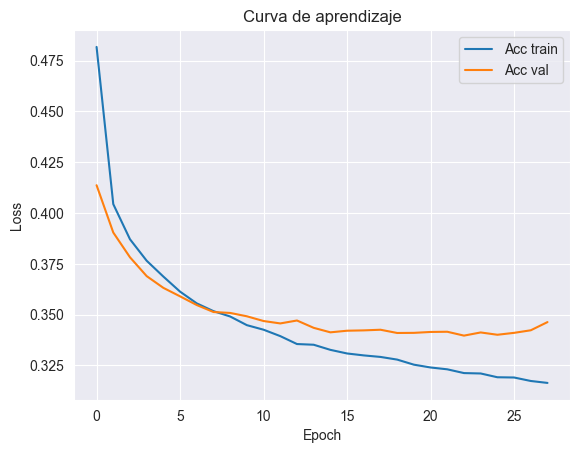

In [24]:
# Se muestra la función de coste del modelo
plt.plot(history.history['loss'], label='Acc train')
plt.plot(history.history['val_loss'], label='Acc val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Curva de aprendizaje')
plt.legend()
plt.show()

547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step


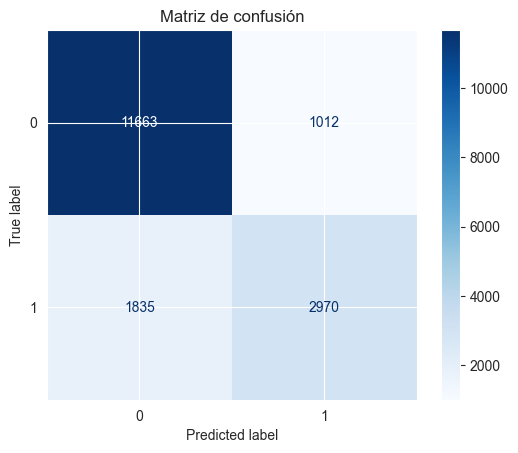

In [25]:
# Hacer predicciones y convertir probabilidades a 0/1
y_pred_prob = model_nn.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Matriz de confusión')
plt.show()

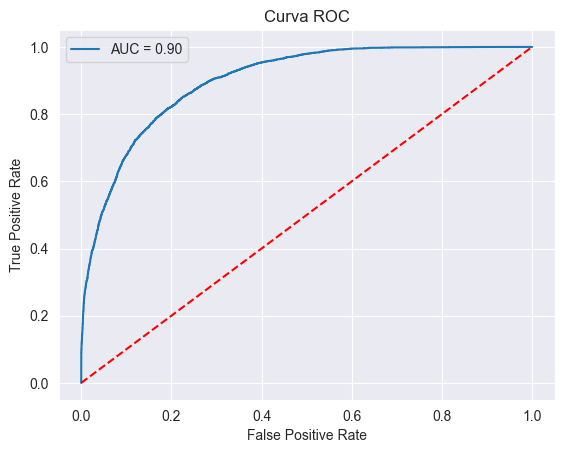

In [26]:
# Obtenemos la curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [27]:
# Obtención de las métricas de evaluación
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Cálculo del AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy:  {acc:.2f}")
print(f"Precisión: {prec:.2f}")
print(f"Recall:    {rec:.2f}")
print(f"F1-Score:  {f1:.2f}")
print(f"AUC:       {auc:.2f}\n")

Accuracy:  0.84
Precisión: 0.75
Recall:    0.62
F1-Score:  0.68
AUC:       0.90

